##Research Question
Can we predict if a patient will miss their medical appointment based on demographic and medical features such as age, gender, health conditions, and whether they received an SMS reminder?

#Step 0: Data Loading and Initial Exploration

Importing Libraries Imported libraries for data handling (Pandas, NumPy), visualization (Seaborn, Matplotlib), model building and evaluation (Scikit-learn), and saving models (Joblib).

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
import shap
import joblib
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay




**Load Dataset**
Loaded the medical appointments dataset using Pandas and displayed the first few rows.

In [69]:
df = pd.read_csv("MedicalAppointmentNoShows.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [70]:
df.shape

(110527, 14)

Our data contains 14 columns, and 110527 observations

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


- we can see here that is no non-null data at all.

In [72]:
df.describe()
print("Min & Max values for numerical columns:")
print(df.describe().loc[["min", "max"]])

Min & Max values for numerical columns:
        PatientId  AppointmentID    Age  Scholarship  Hipertension  Diabetes  \
min  3.921784e+04      5030230.0   -1.0          0.0           0.0       0.0   
max  9.999816e+14      5790484.0  115.0          1.0           1.0       1.0   

     Alcoholism  Handcap  SMS_received  
min         0.0      0.0           0.0  
max         1.0      4.0           1.0  


Displayed summary statistics and checked min/max values for numerical columns to detect anomalies
- we noticed there is an observation with age who is -1 (we will take care of it on data cleaning)

#Step 1: EDA

In [73]:
sns.set(style="whitegrid")

In [74]:
def plot_categorical(data, column):
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))

    sns.countplot(x=column, data=data, ax=ax[0], order=data[column].value_counts().index)
    ax[0].set_title(f'Bar plot of {column}')
    ax[0].tick_params(axis='x', rotation=90)

    top_values = data[column].value_counts().head(10)
    top_values.plot.pie(autopct='%1.1f%%', ax=ax[1], startangle=90)
    ax[1].set_title(f'Pie chart of {column} (Top 10)')
    ax[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

ScheduledDay & AppointmentDay got too many unique values.

we will choose which values we want to describe as Pie Chart.

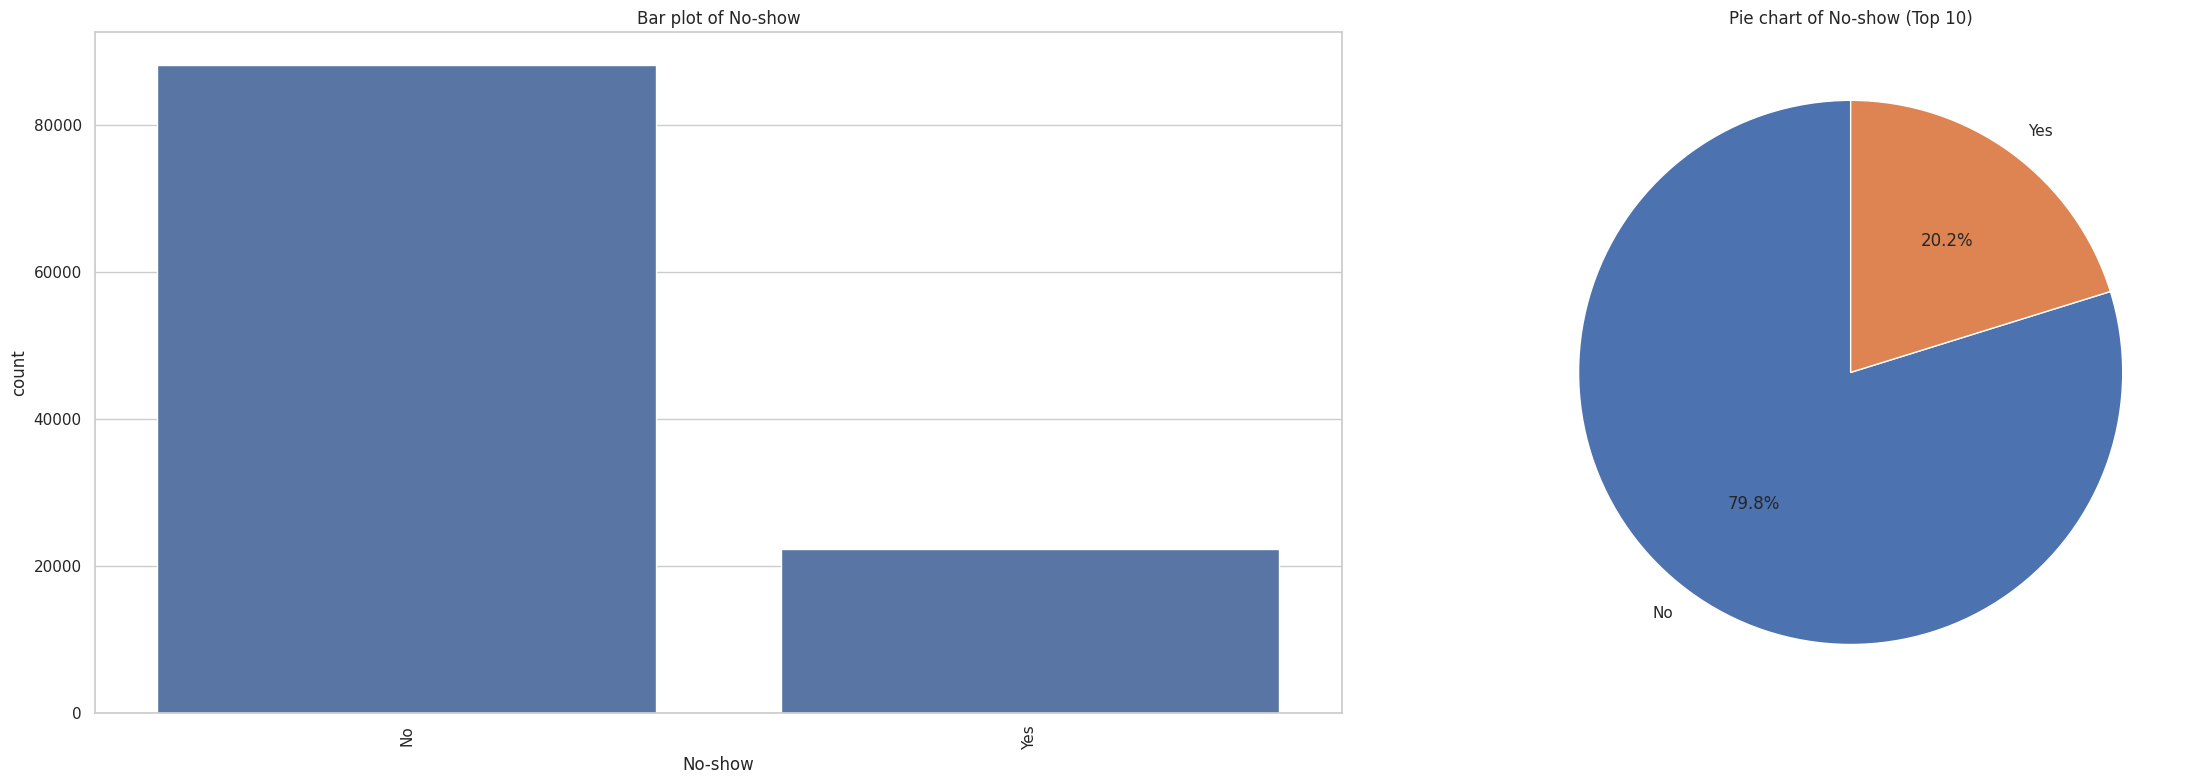

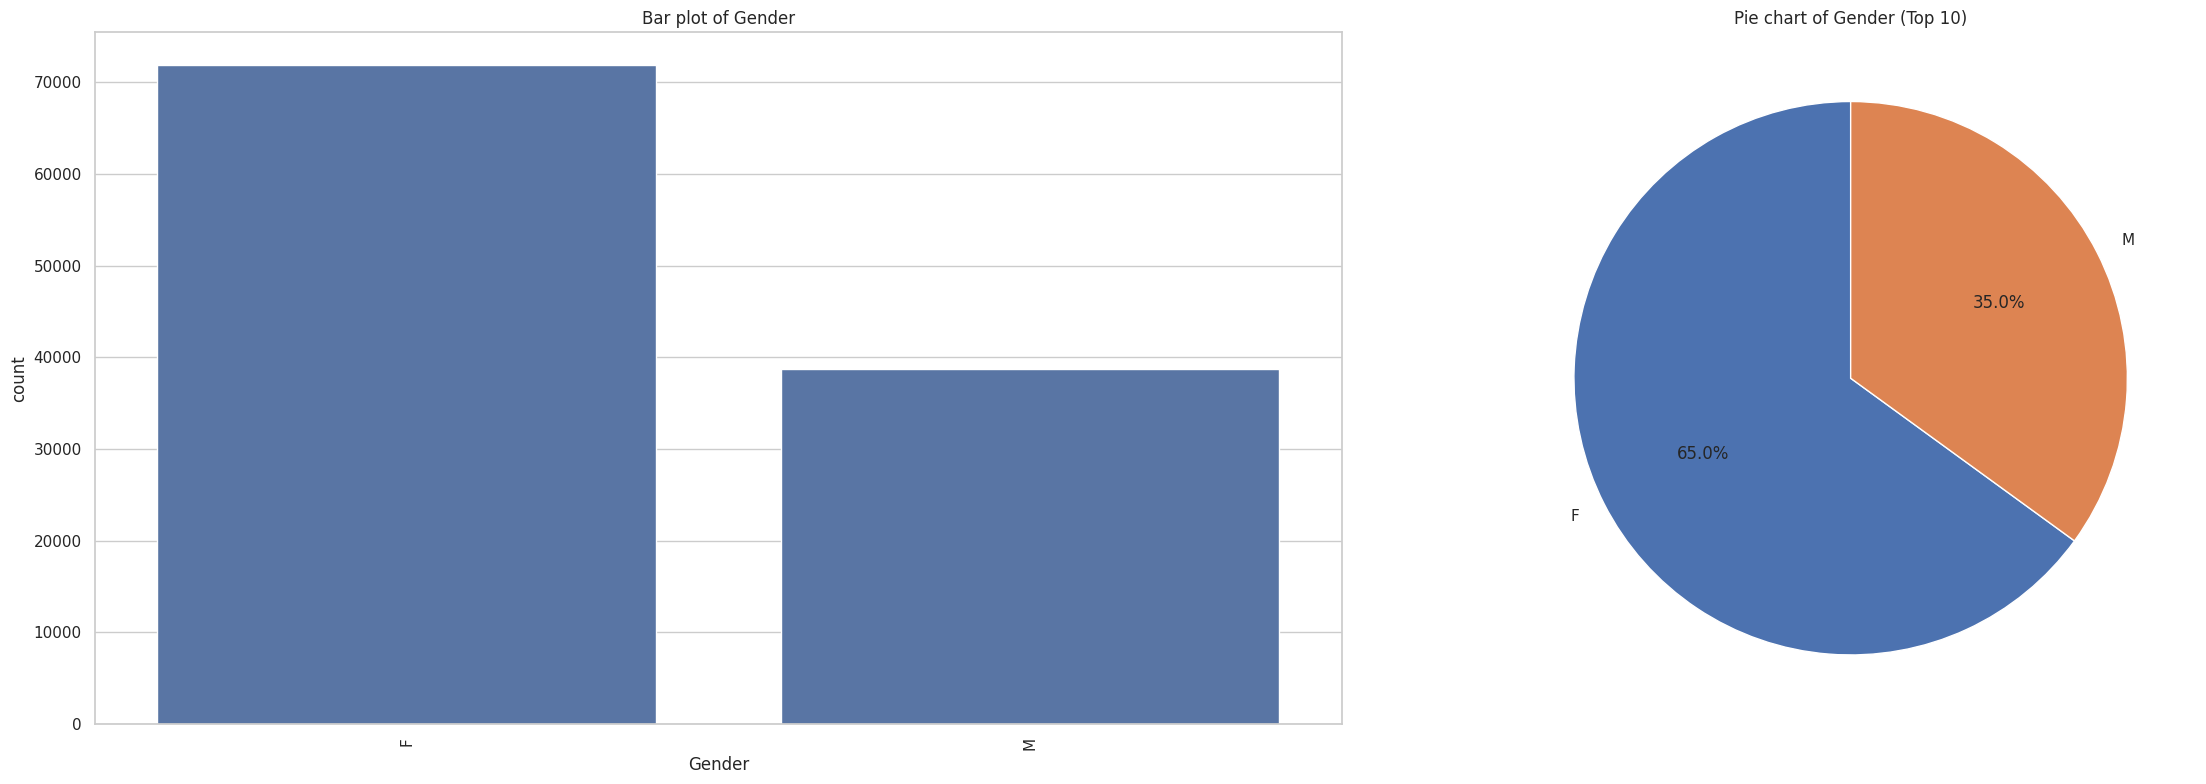

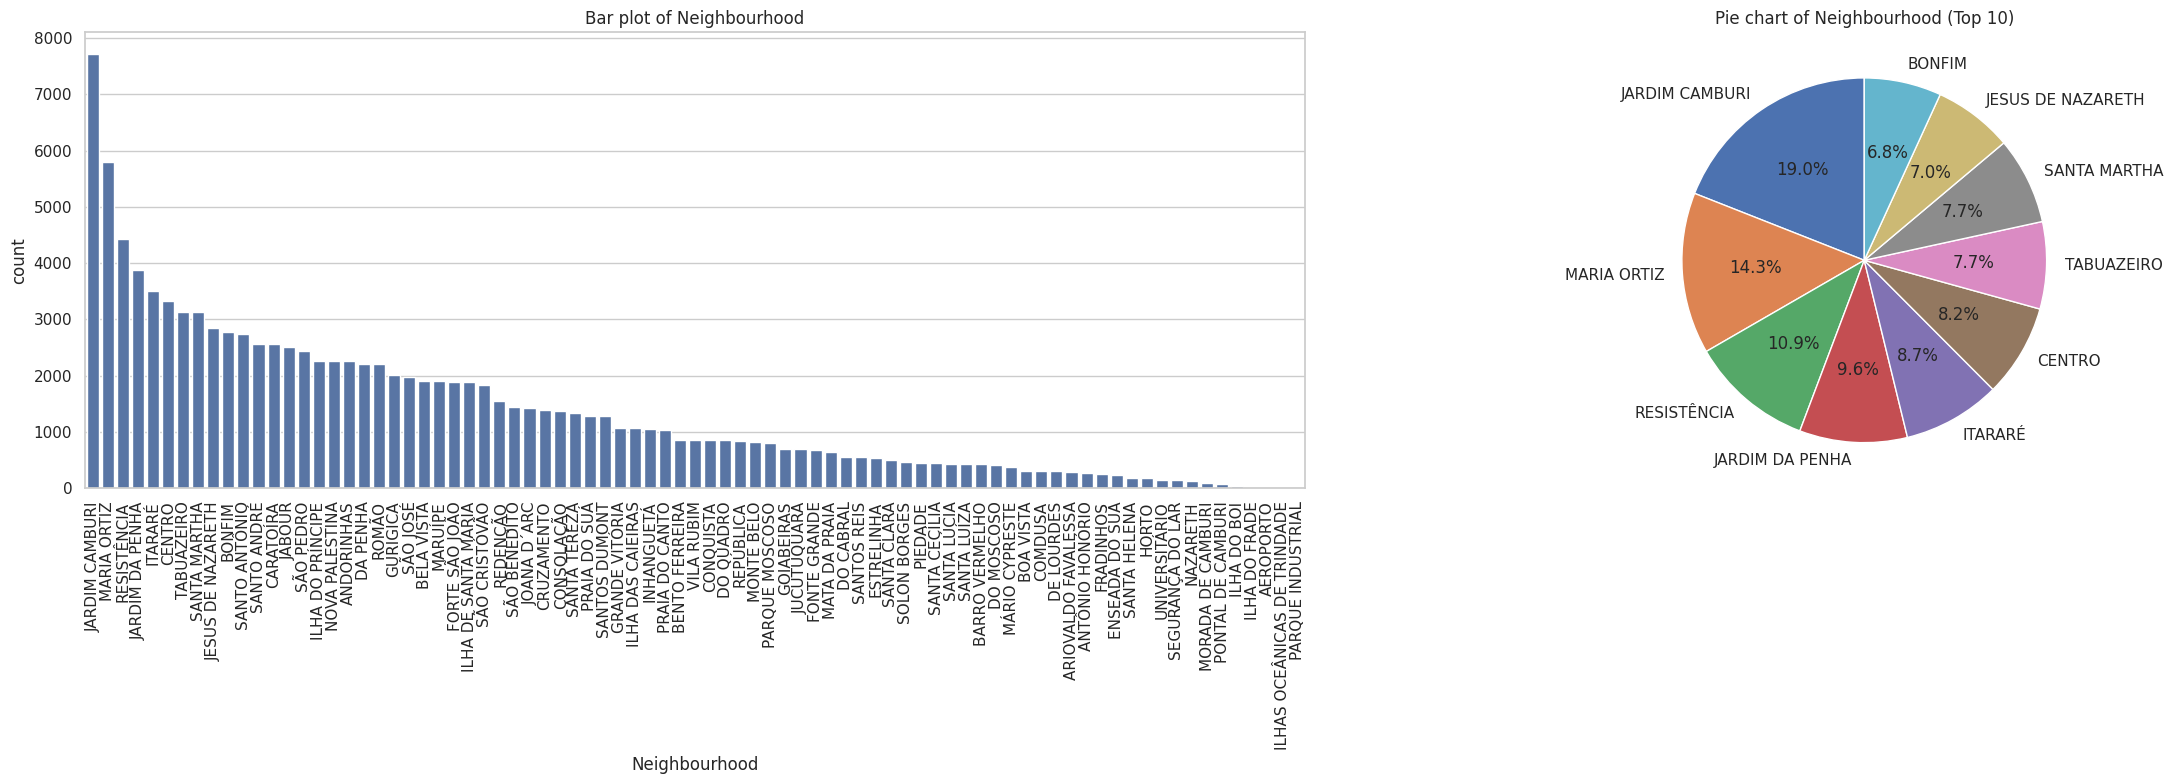

In [75]:
plot_categorical(df, 'No-show')
plot_categorical(df, 'Gender')
plot_categorical(df, 'Neighbourhood')

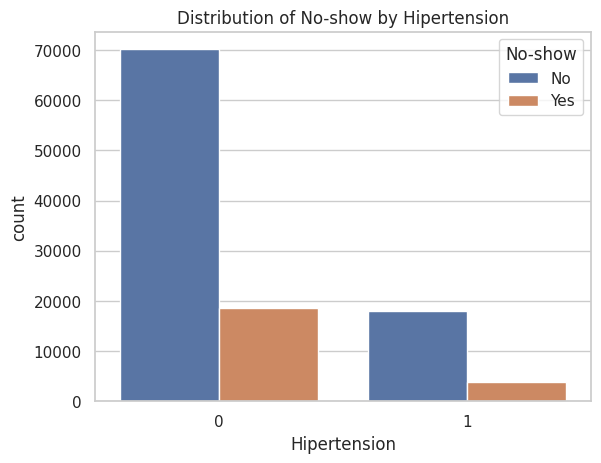

In [76]:
sns.countplot(x="Hipertension", hue="No-show", data=df)
plt.title("Distribution of No-show by Hipertension")
plt.show()

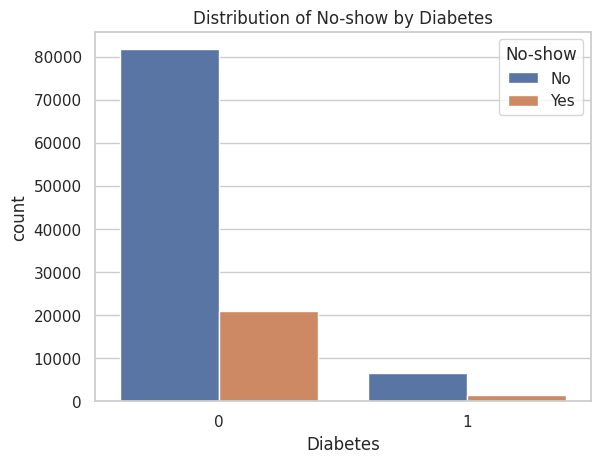

In [77]:
sns.countplot(x="Diabetes", hue="No-show", data=df)
plt.title("Distribution of No-show by Diabetes")
plt.show()


In [78]:
def plot_numerical(df, column):

    plt.figure(figsize=(7, 4))
    sns.histplot(df[column], kde=True, bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

To explore a numerical feature, I created a function that plots its distribution using a histogram with a KDE (density curve).
It helps visualize how the values are spread and whether the data is skewed or normally distributed.



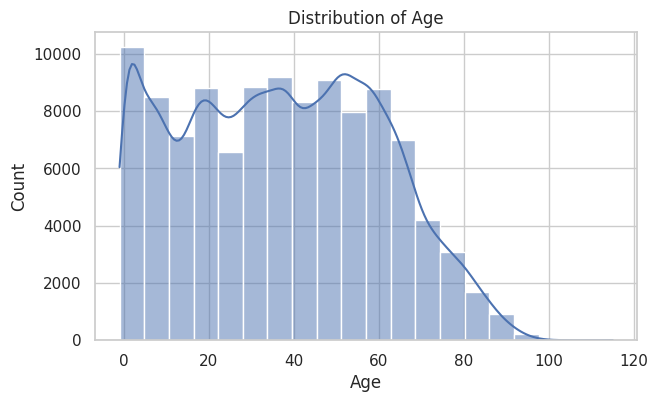

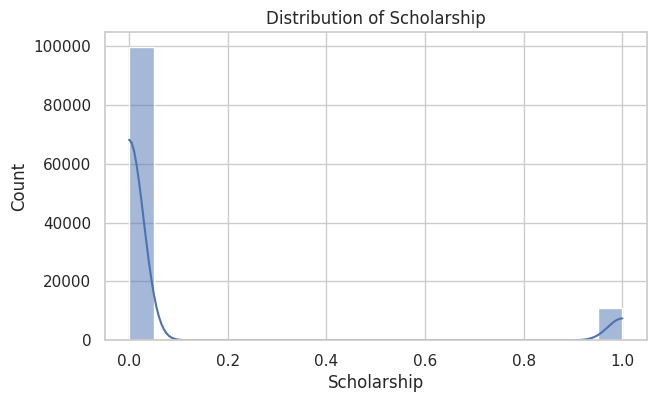

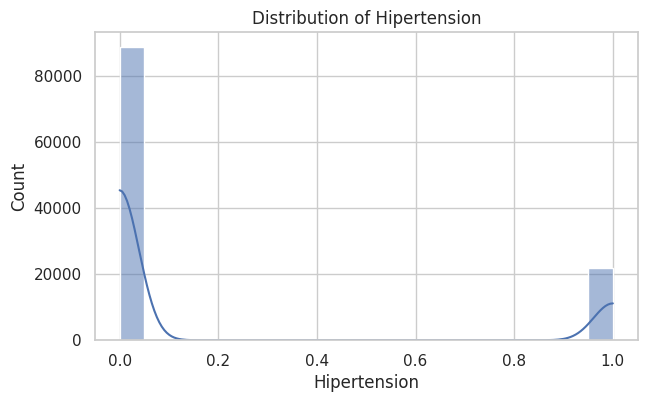

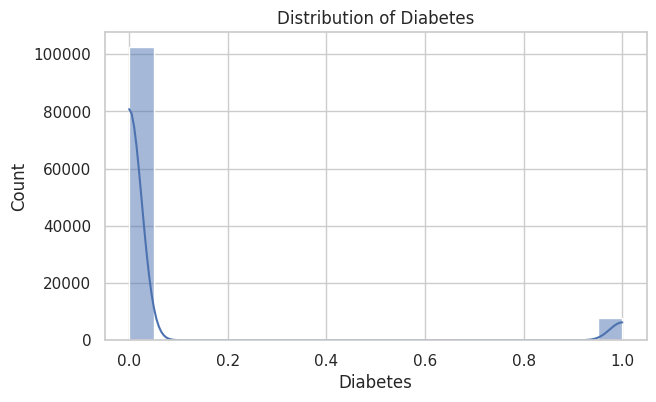

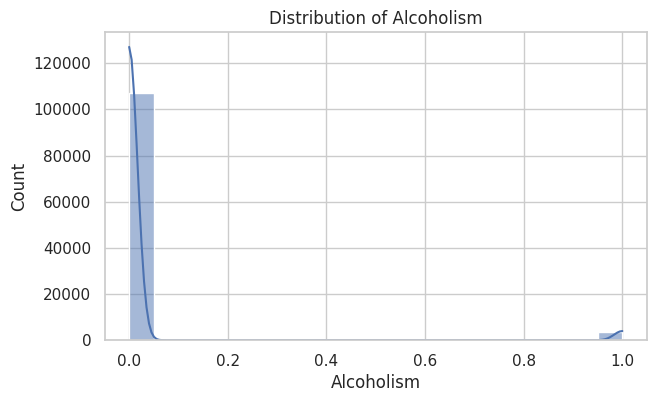

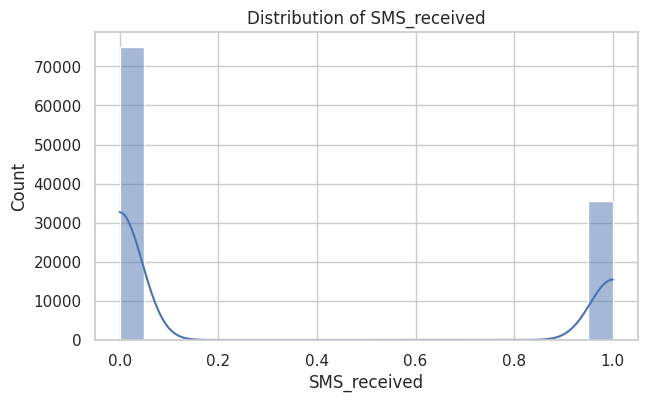

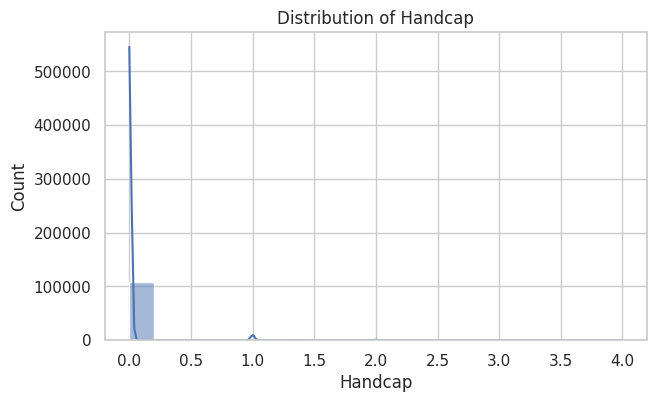

In [79]:
for column in ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'Handcap']:
    plot_numerical(df, column)


I  used a loop to generate distribution plots for several numerical and binary features, in order to better understand their value spread and detect patterns or imbalances in the data.



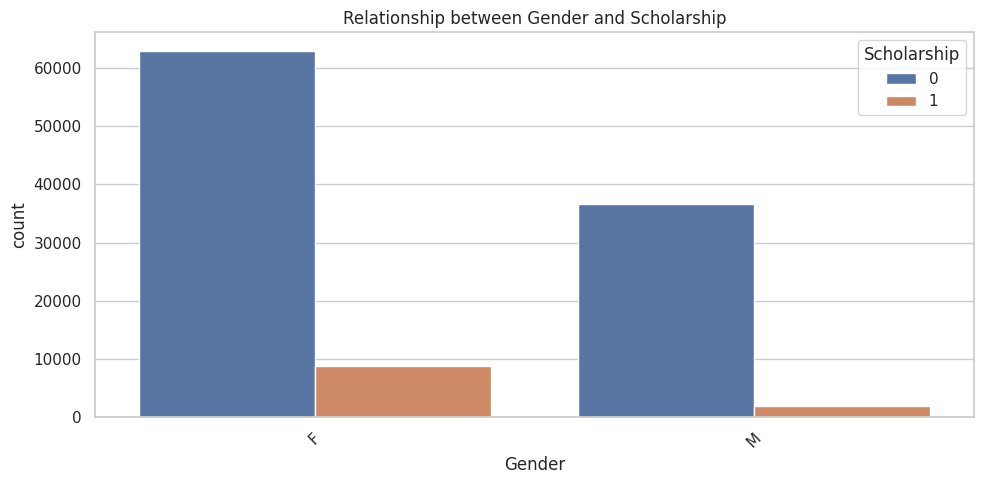

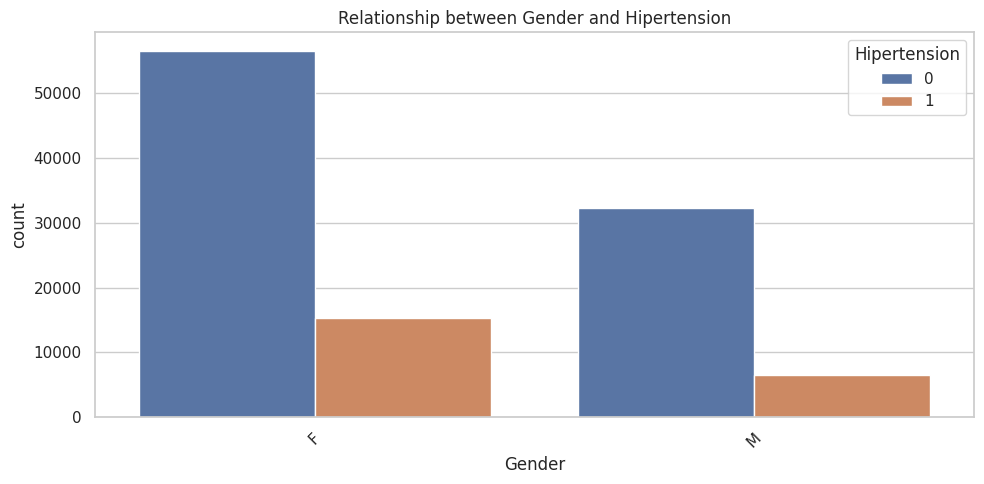

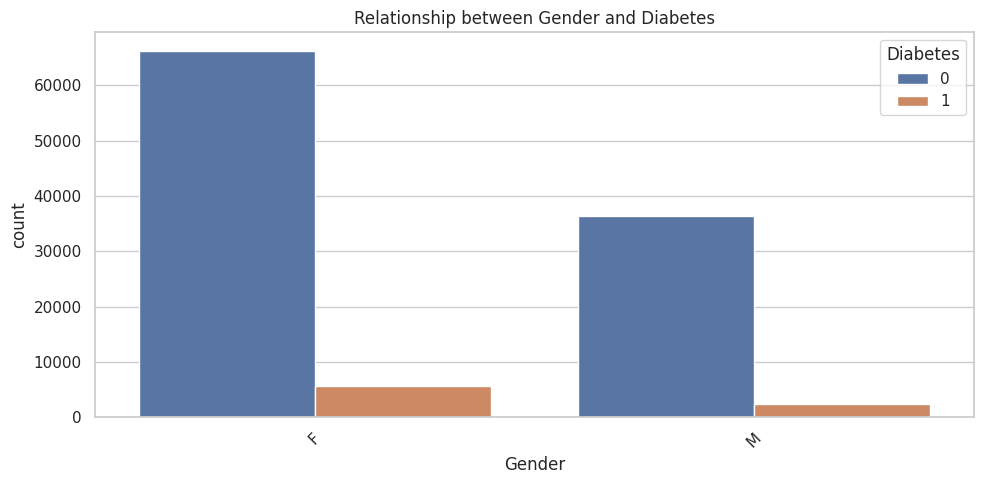

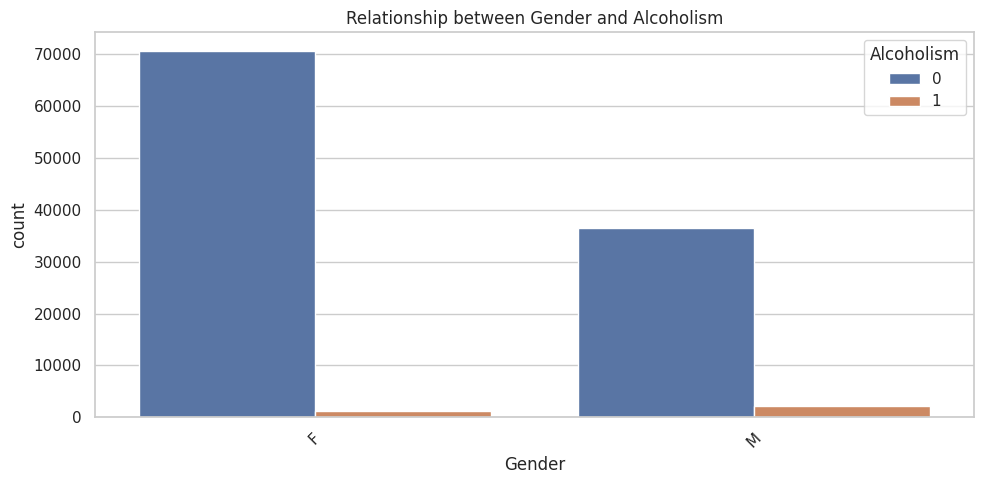

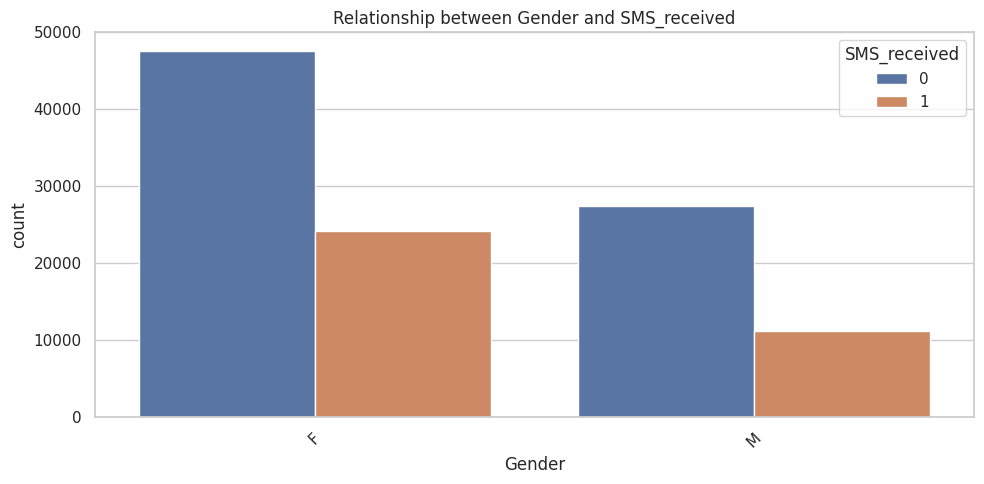

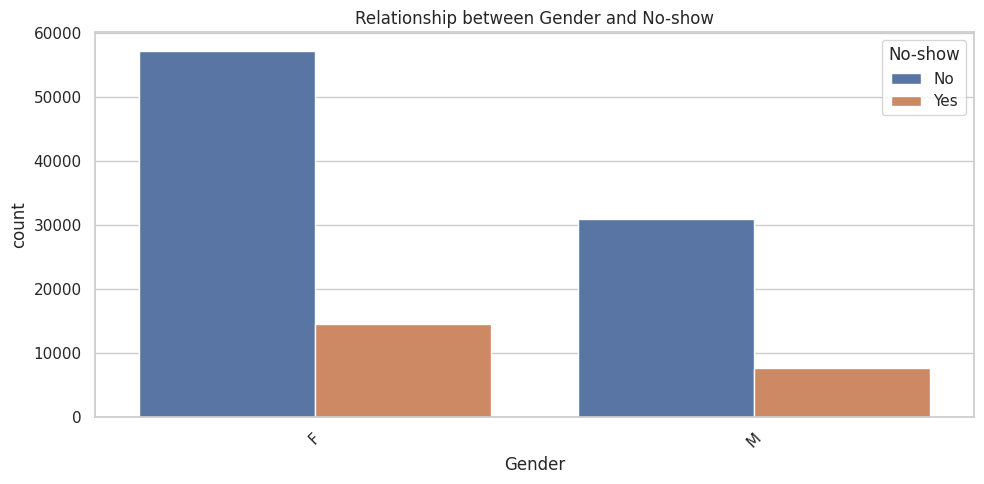

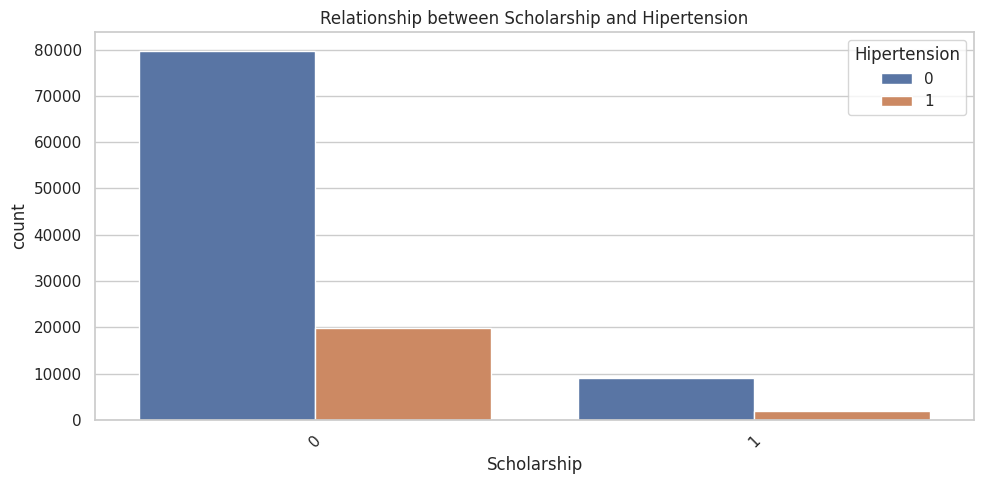

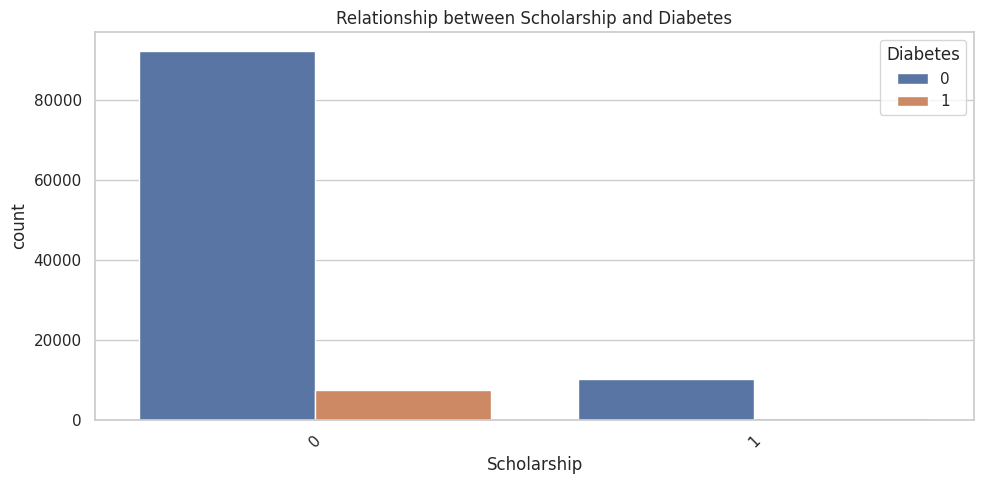

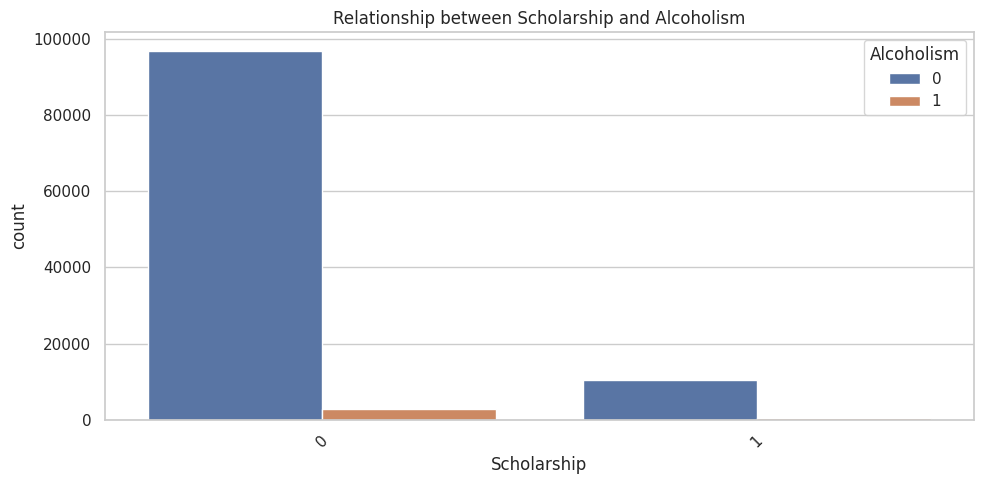

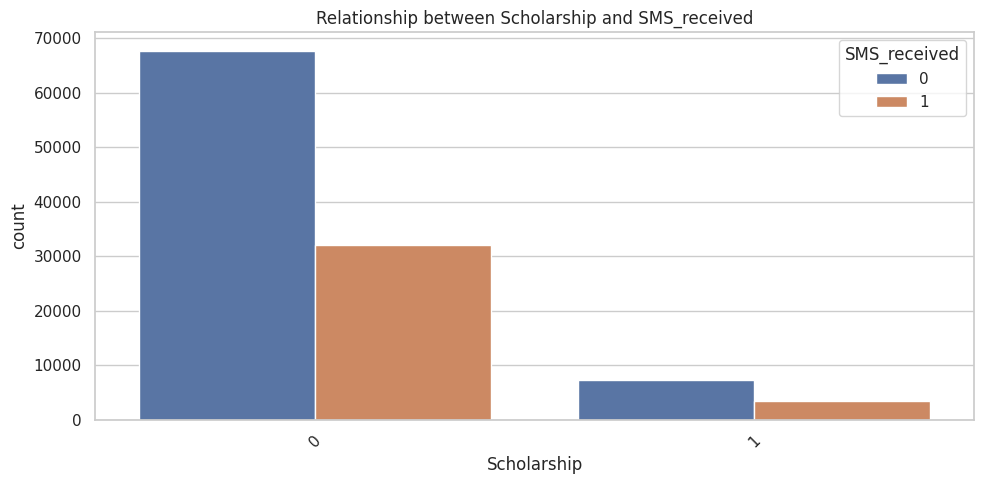

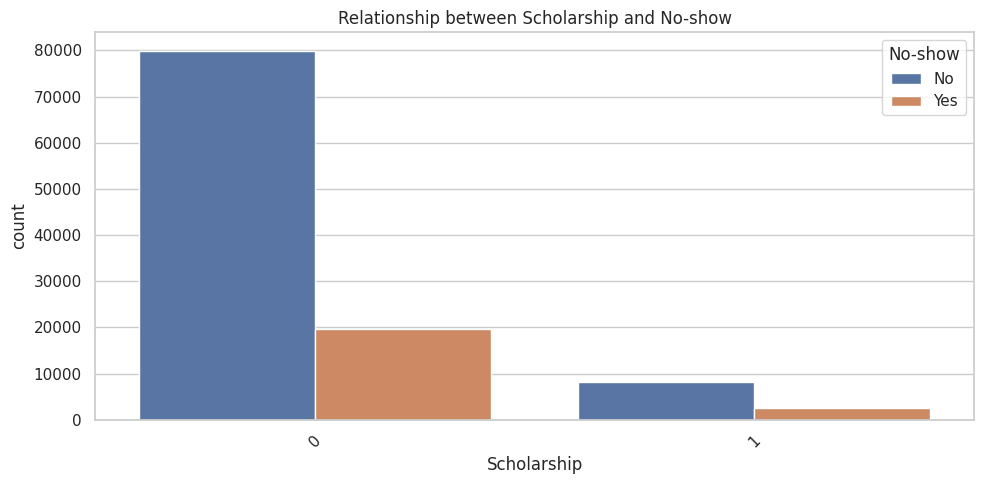

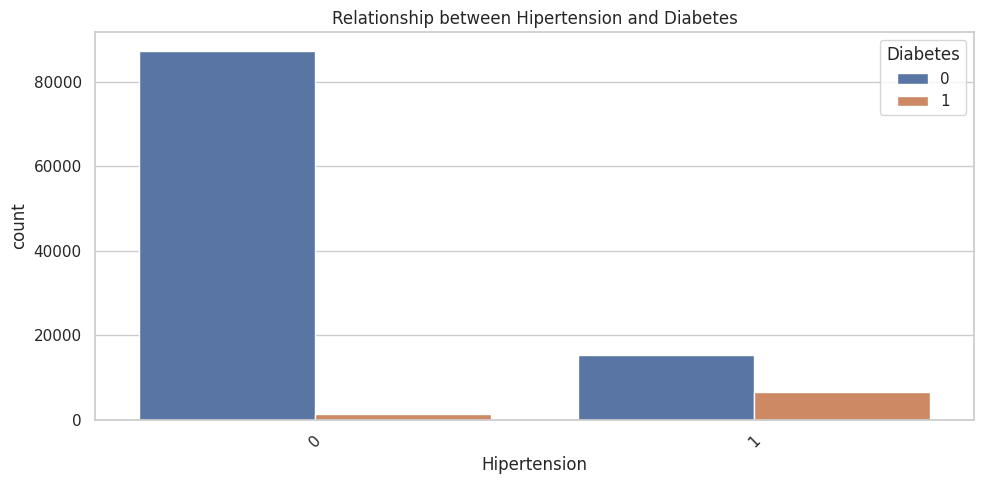

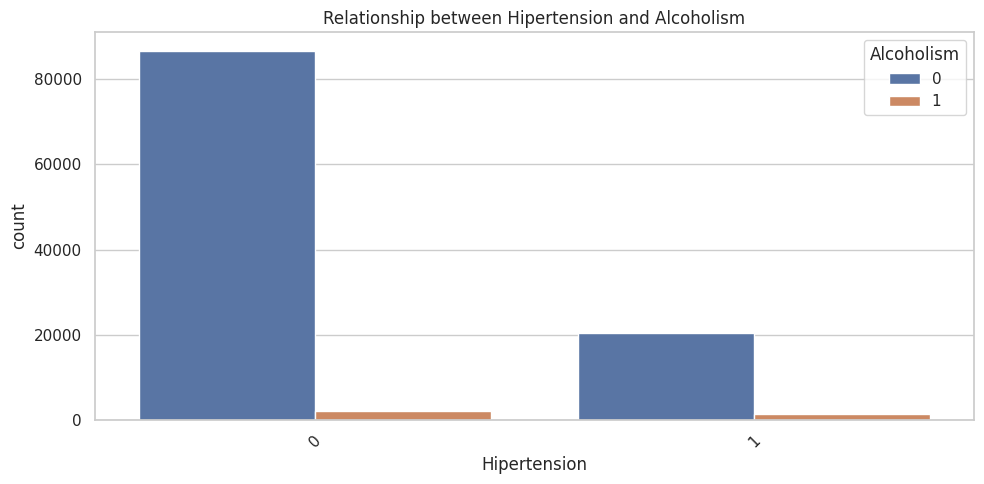

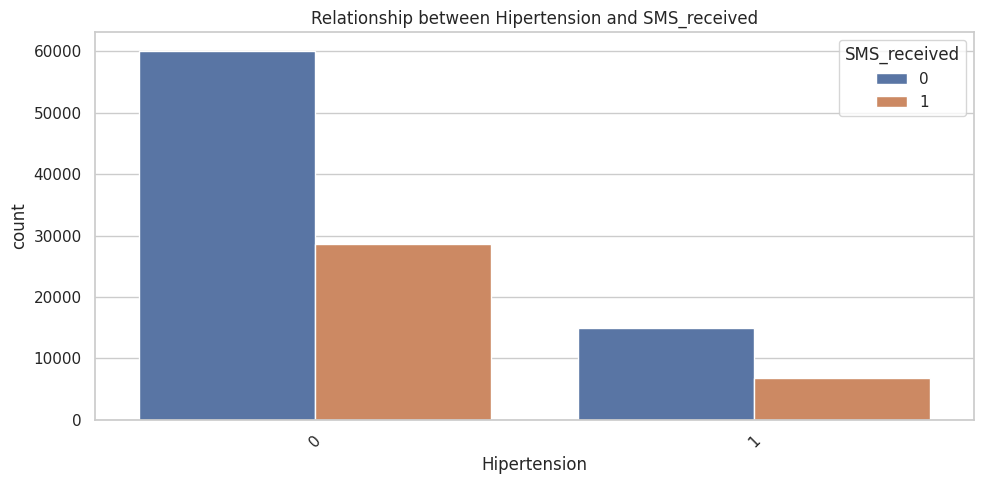

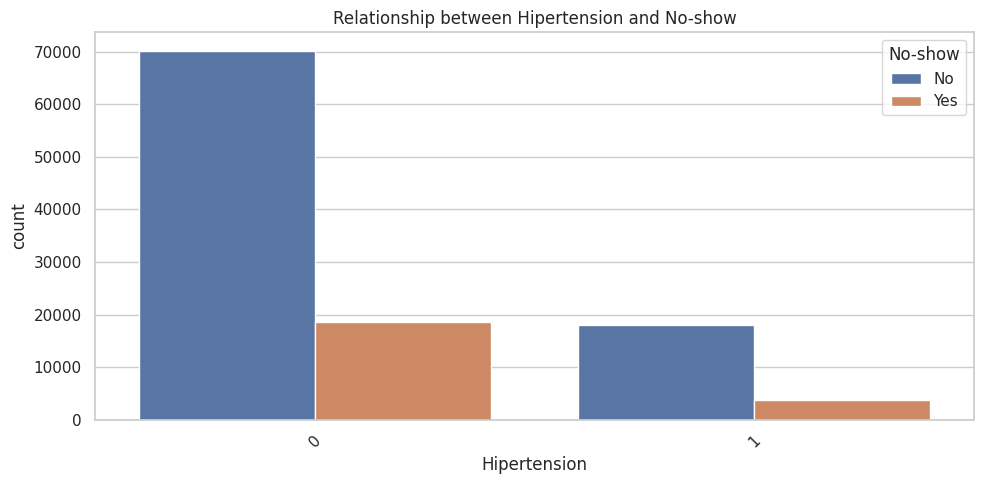

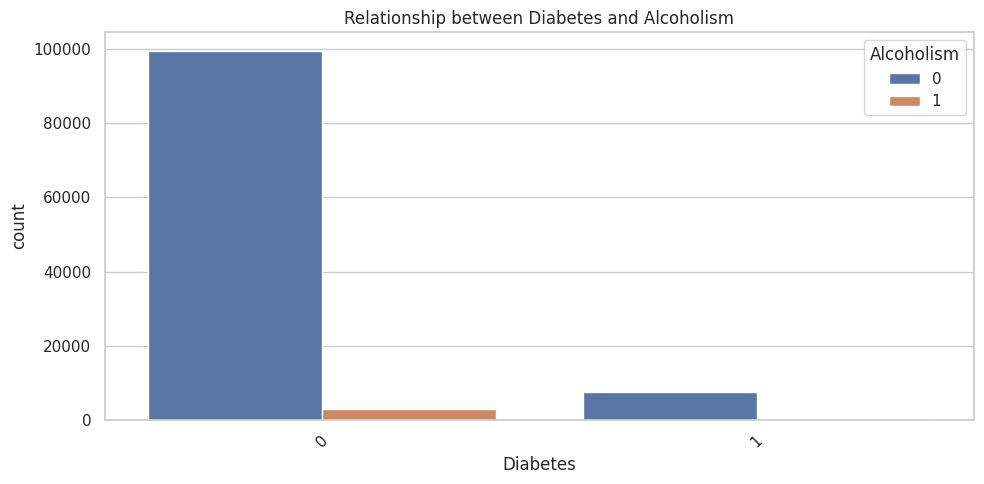

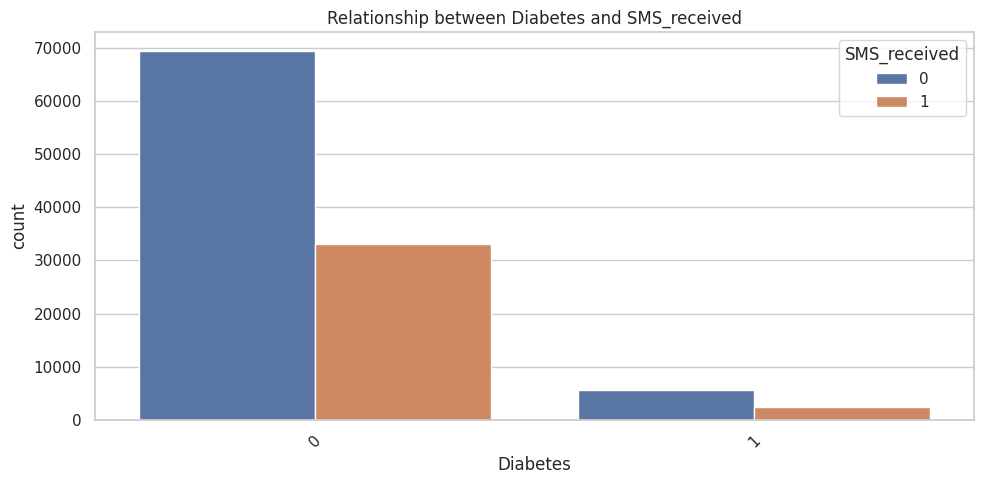

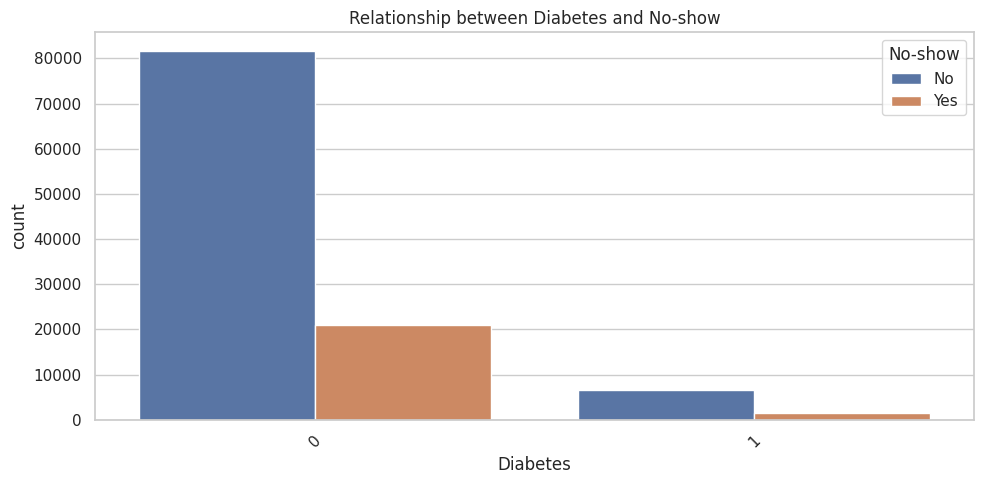

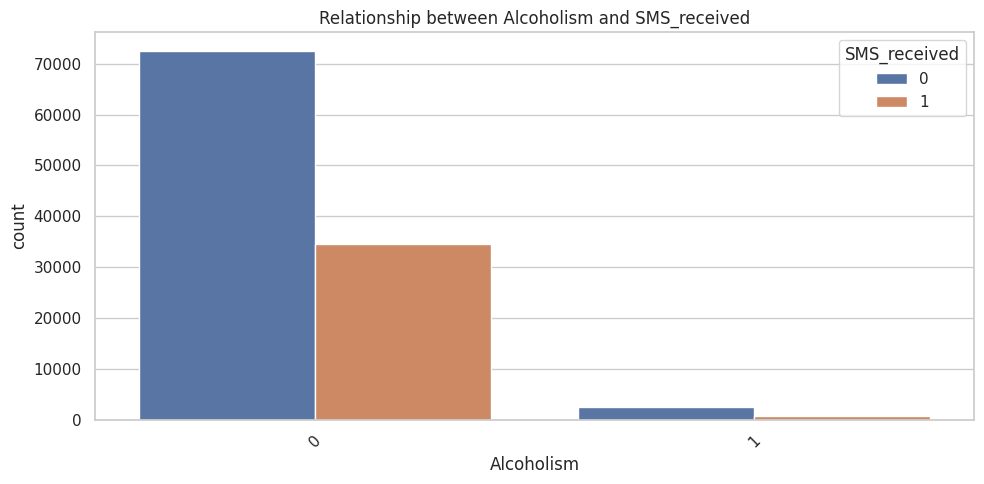

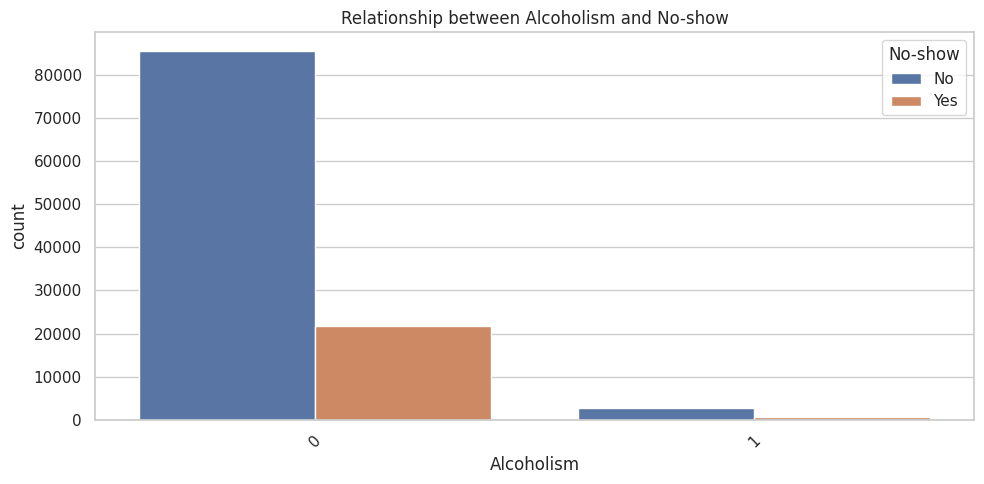

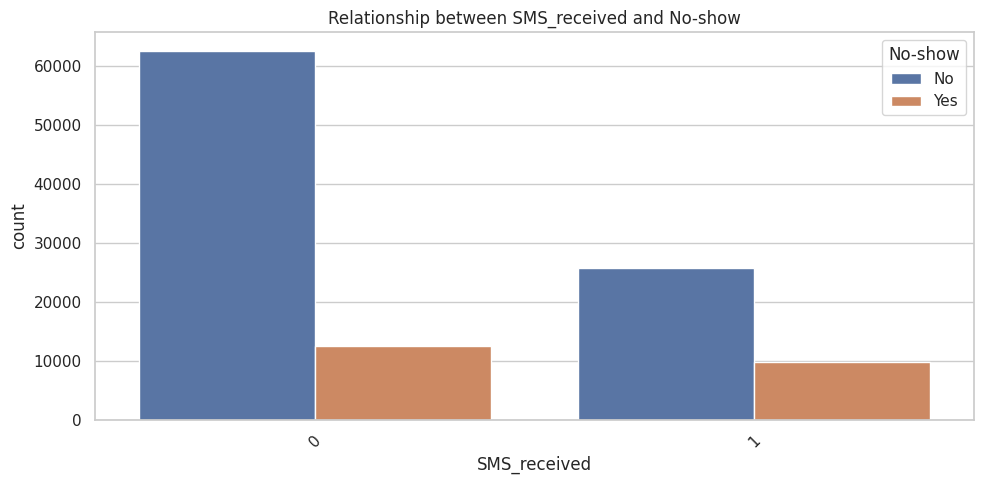

In [80]:
cat_columns = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes',
               'Alcoholism', 'SMS_received', 'No-show']

for i in range(len(cat_columns)):
    for j in range(i + 1, len(cat_columns)):
        plt.figure(figsize=(10, 5))
        sns.countplot(x=cat_columns[i], hue=cat_columns[j], data=df)
        plt.title(f'Relationship between {cat_columns[i]} and {cat_columns[j]}')
        plt.legend(title=cat_columns[j])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

 To analyze relationships between categorical features, I used nested loops to generate multiple countplots.
Each plot shows how the values of one categorical feature are distributed with respect to another, helping identify potential correlations or patterns.

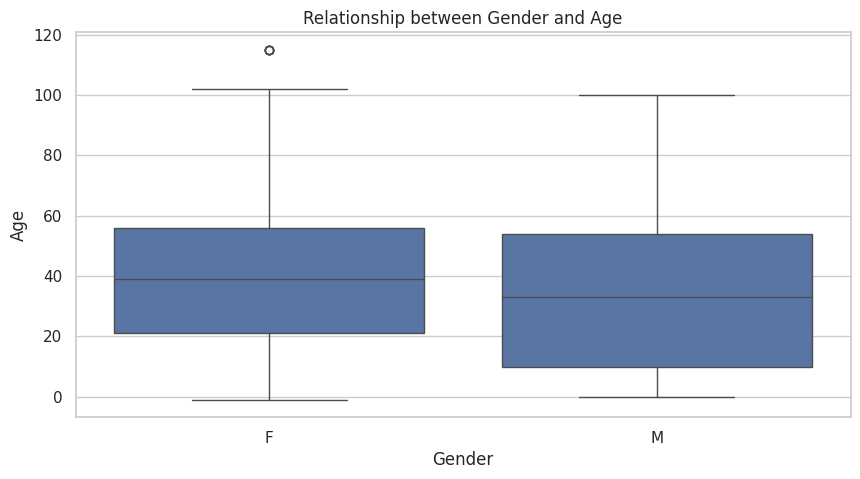

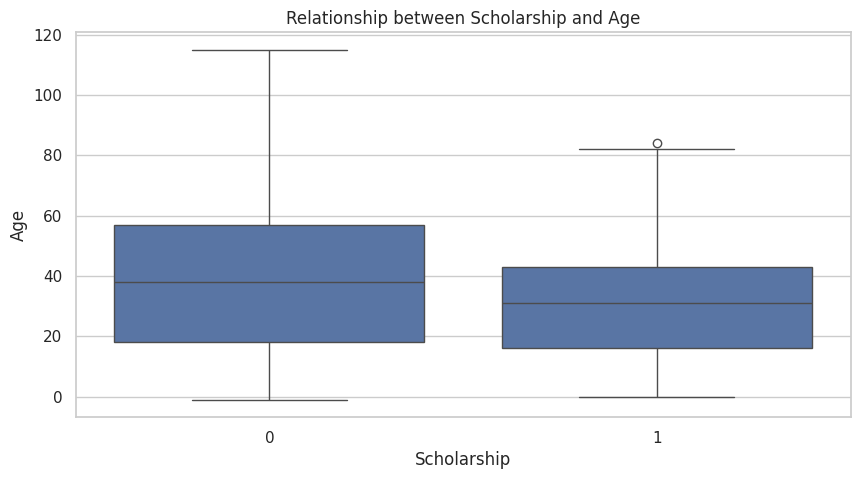

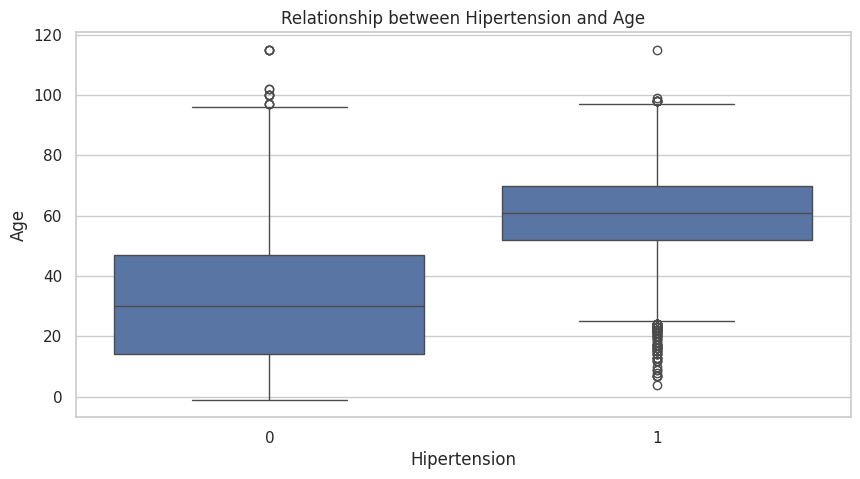

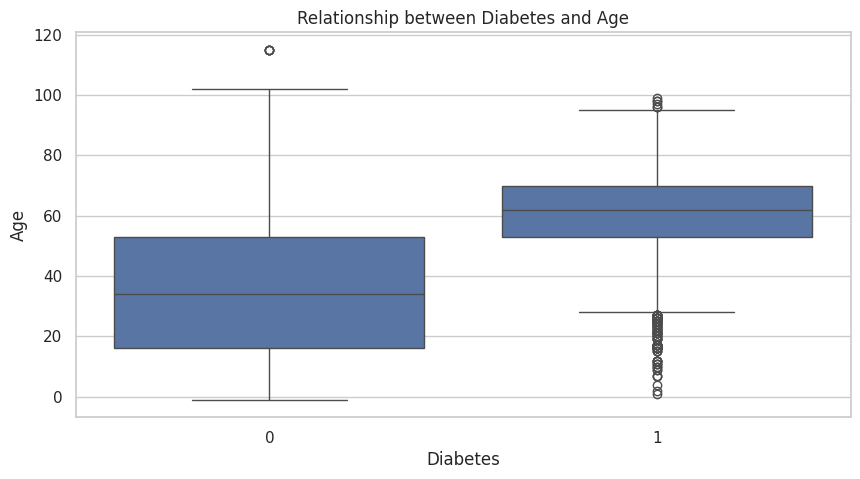

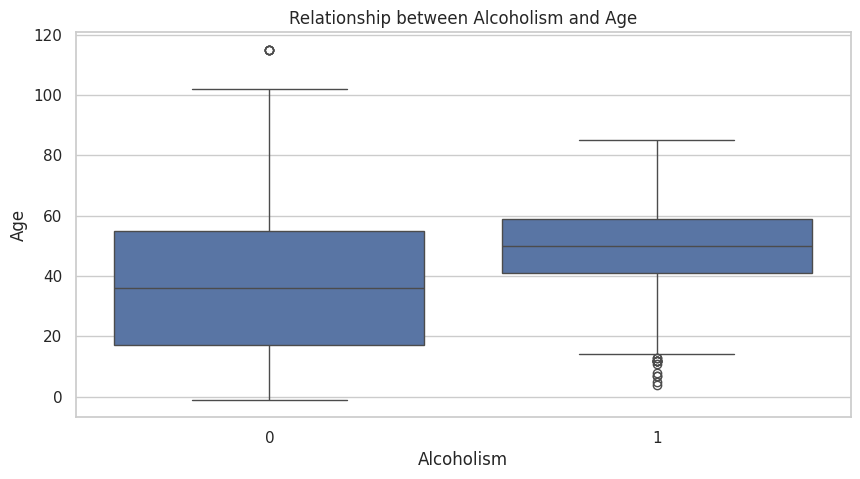

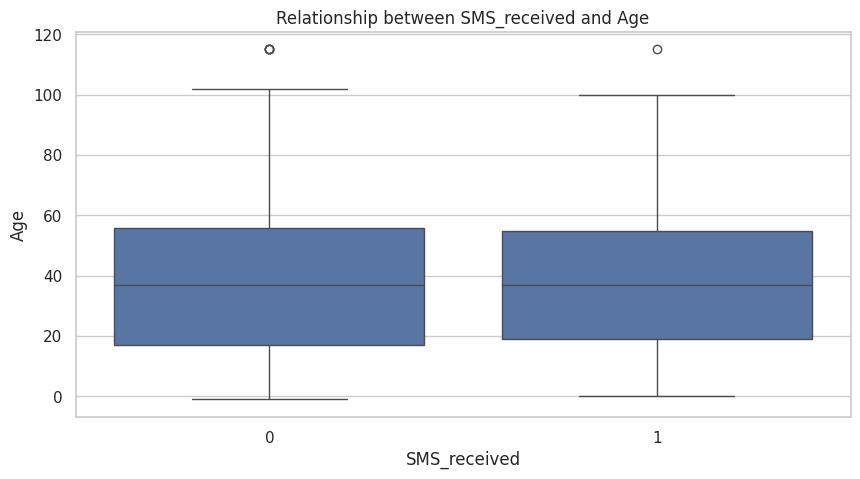

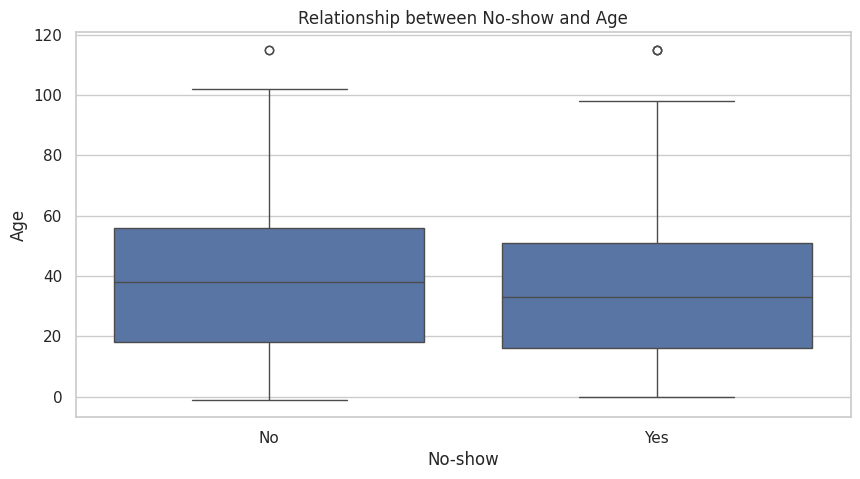

In [81]:
num_columns = ['Age']
cat_columns = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes',
               'Alcoholism', 'SMS_received', 'No-show']

for num_col in num_columns:
    for cat_col in cat_columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=cat_col, y=num_col, data=df)
        plt.title(f'Relationship between {cat_col} and {num_col}')
        plt.xlabel(cat_col)
        plt.ylabel(num_col)
        plt.show()

To examine how the numerical feature Age varies across different categorical groups, I used boxplots.
This helped identify trends, differences, or outliers in age distributions based on categories like gender, medical conditions, and no-show status.



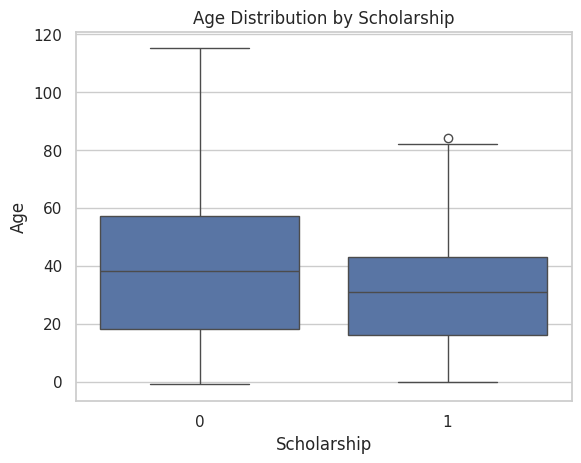

In [82]:
sns.boxplot(x='Scholarship', y='Age', data=df)
plt.title('Age Distribution by Scholarship')
plt.show()

I used a boxplot to visualize the age distribution based on scholarship status.
This allowed me to compare age ranges between patients who received a scholarship and those who did not.



#Step 2: Data Cleaning

**Data Quality Check**
Checked for missing values and duplicate rows in the dataset

In [83]:
print("Missing values per column:")
print(df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

Missing values per column:
PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

Duplicate rows: 0


- Convert raw date columns to datetime format to compute waiting days between scheduling and appointment.
- Drop identifiers and raw date fields afterwards, keeping only 'WaitingDays' as a meaningful feature.

- **Dropping Irrelevant Columns**
Removed ID columns that are not useful for prediction.




**After some inspection, I found an invalid age value of -1. Since negative age is not possible, I removed such entries from the dataset.**

In [84]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.normalize()
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.normalize()

df['WaitingDays'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

print(f"SUM of Rows before Cleaning: {df.shape[0]}")

df = df[(df['Age'] >= 0) & (df['WaitingDays'] >= 0)]

print(f"SUM of Rows after cleaning: {df.shape[0]}")

diff = 110527 - df.shape[0]
print(f"SUM of the Deleted rows: {diff}")

SUM of Rows before Cleaning: 110527
SUM of Rows after cleaning: 110521
SUM of the Deleted rows: 6


In [85]:
df['DayOfWeek'] = df['AppointmentDay'].dt.day_name()

df.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], inplace=True)

print("Features added: DayOfWeek")

print(df[['DayOfWeek', 'WaitingDays']].head(10))

Features added: DayOfWeek
  DayOfWeek  WaitingDays
0    Friday            0
1    Friday            0
2    Friday            0
3    Friday            0
4    Friday            0
5    Friday            2
6    Friday            2
7    Friday            2
8    Friday            0
9    Friday            2


Separate features (X) and target (y)

In [86]:

y = df['No-show'].map({'Yes': 1, 'No': 0})
X = df.drop(columns='No-show')

Identify numerical and categorical features

In [87]:
numerical_features = ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'Handcap', 'WaitingDays']
categorical_features = ['Gender', 'Neighbourhood']

I assumed that (handcap) levels exist, so values between 0 and 4 are considered valid.

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110521 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Gender         110521 non-null  object
 1   Age            110521 non-null  int64 
 2   Neighbourhood  110521 non-null  object
 3   Scholarship    110521 non-null  int64 
 4   Hipertension   110521 non-null  int64 
 5   Diabetes       110521 non-null  int64 
 6   Alcoholism     110521 non-null  int64 
 7   Handcap        110521 non-null  int64 
 8   SMS_received   110521 non-null  int64 
 9   No-show        110521 non-null  object
 10  WaitingDays    110521 non-null  int64 
 11  DayOfWeek      110521 non-null  object
dtypes: int64(8), object(4)
memory usage: 11.0+ MB


 1 observation has been deleted (that one who got -1 on age column) so it make sense.

#Step 3: Stratified Train-Test Split

In [89]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

I used StratifiedShuffleSplit to split the data into training and test sets while preserving the original class distribution in the target variable.
This ensures that both sets are representative and reduces the risk of bias, especially for imbalanced data.



#Step 4: Calculate outliers

In [90]:
Q1 = X_train[numerical_features].quantile(0.25)
Q3 = X_train[numerical_features].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

non_outliers = ((X_train[numerical_features] >= lower_bound) & (X_train[numerical_features] <= upper_bound)).all(axis=1)
X_train = X_train[non_outliers]
y_train = y_train.loc[X_train.index]

 This code identifies and removes outliers from the training dataset using the Interquartile Range (IQR) method. It ensures that only data points within the defined non-outlier range remain in X_train and updates y_train accordingly to maintain alignment.

#Step 5: Preprocessing Pipelines for Numerical and Categorical Features

In [91]:
num_pipe = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical_features),
    ('cat', cat_pipe, categorical_features)
])

To preprocess the data, I used a ColumnTransformer that applies separate pipelines for numerical and categorical features.
For numerical columns, I applied KNN imputation and scaling.
For categorical columns, I used most frequent imputation and one-hot encoding

#Step 6: Define Models and Hyperparameter Grids

In [92]:
models = {
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
}

param_grid = {
    "KNN": {"n_neighbors": [3, 5, 7], "metric": ["euclidean"]},
    "Naive Bayes": {},
    "Random Forest": {
        "n_estimators": [100],
        "max_depth": [10, 20],
        "min_samples_split": [5]
    }
}

I defined three classification models: K-Nearest Neighbors (KNN), Naive Bayes, and Random Forest.
For each model, I set up a corresponding hyperparameter grid to be used later for tuning via GridSearchCV.



#Step 7: Hyperparameter Tuning with GridSearchCV

 Recall is prioritized over accuracy because in our problem, it's more important to identify as many No-Show patients as possible (True Positives), even if that includes predicting some patients as No-Show when they are not (False Positives). This helps reduce clinic inefficiency and resource waste.

In [93]:
best_model = None
best_score = 0

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    full_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('pca', PCA(n_components=0.95, svd_solver='full')),
        ('clf', model)
    ])

    clf_param_grid = {f"clf__{k}": v for k, v in param_grid[model_name].items()} if param_grid[model_name] else {}

    grid = GridSearchCV(
        estimator=full_pipeline,
        param_grid=clf_param_grid,
        cv=3,
        scoring="recall",
        n_jobs=-1,
        verbose=2
    )

    grid.fit(X_train, y_train)

    print(f"{model_name} Best Params: {grid.best_params_}")
    print(f"CV Recall: {grid.best_score_:.3f}")

    if grid.best_score_ > best_score:
        best_model = grid.best_estimator_
        best_score = grid.best_score_


Training KNN...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
KNN Best Params: {'clf__metric': 'euclidean', 'clf__n_neighbors': 7}
CV Recall: 0.579

Training Naive Bayes...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Naive Bayes Best Params: {}
CV Recall: 0.558

Training Random Forest...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Random Forest Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
CV Recall: 0.761


 The best performing model is Random Forest with an optimized cross-validation Recall of 76.1%


#Step 8: Evaluate on Test Set


 Evaluation on Test Set:
Accuracy:  0.625
Precision: 0.314
Recall:    0.728
F1 Score:  0.439


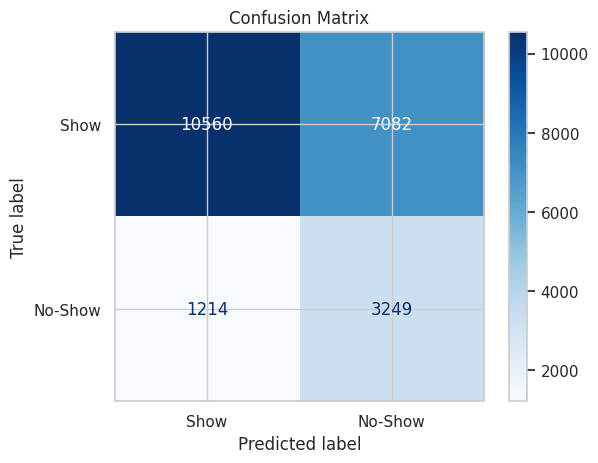

In [94]:
y_pred = best_model.predict(X_test)

print("\n Evaluation on Test Set:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Show", "No-Show"], cmap="Blues")

plt.title("Confusion Matrix")
plt.show()

- The model achieves 62.5% accuracy, with a recall of 72.8% for detecting No-Show patients.

This means the model successfully identified 72.8% of patients who missed their appointment, which is the main goal of the project.
However, the precision is 31.4%, indicating that about 1 in 3 patients predicted as 'No-Show' truly missed their appointment.
The balance between precision and recall yields an F1 score of 43.9%, reflecting a moderate overall performance.

- The F1-score (0.439) offers a balanced metric between precision and recall, highlighting the model’s ability to effectively identify No-Show patients while minimizing false positives — an essential aspect in optimizing appointment scheduling and reducing resource waste in healthcare.

In [95]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.60      0.72     17642
           1       0.31      0.73      0.44      4463

    accuracy                           0.62     22105
   macro avg       0.61      0.66      0.58     22105
weighted avg       0.78      0.62      0.66     22105



- The classification report shows that for the No-Show class (label 1), the model achieves a recall of 73%, meaning it correctly identifies the majority of patients who do not attend their appointments.

- The precision of 31% indicates that some of the patients predicted as No-Show actually did attend.

- The F1-score (0.43) reflects a moderate balance between catching true no-shows and minimizing false alarms.

- While the accuracy is 62%, recall is the more important metric in this case, as the main goal is to reduce missed appointments and wasted resources in the clinic.

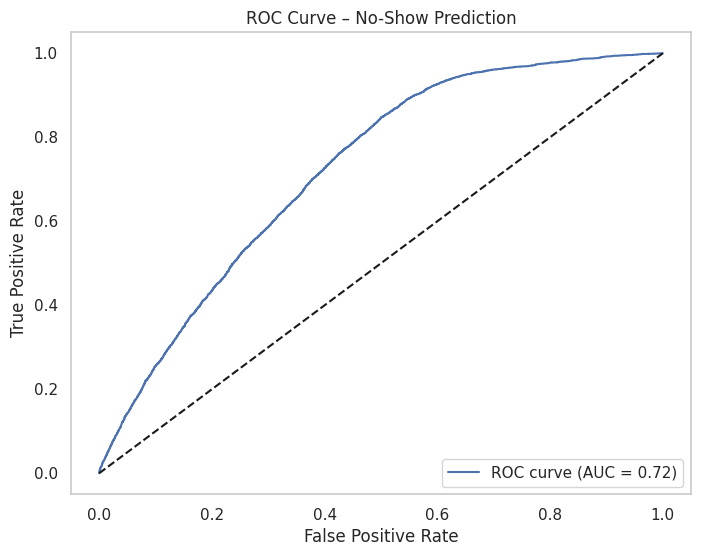

In [96]:
y_scores = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – No-Show Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()



- The ROC curve shows the model’s ability to distinguish between No-Show and Show patients across all classification thresholds.

- With an AUC (Area Under the Curve) of 0.72, the model demonstrates decent discriminatory power — notably better than random guessing (AUC = 0.50).
This suggests the model is effective at ranking patients by their likelihood of missing an appointment, even if exact predictions aren't always correct.

# Step 9: Save the Model and Pipeline

In [97]:
joblib.dump(best_model, "best_model_pipeline.pkl")
print("Model saved successfully as 'best_model_pipeline.pkl'")

Model saved successfully as 'best_model_pipeline.pkl'


# Step 10: Load the Model and Make Predictions on New Data

In [98]:
loaded_model = joblib.load("best_model_pipeline.pkl")
y_pred = loaded_model.predict(X_test)

In [99]:
new_patient = pd.DataFrame([{
    "Gender": "F",
    "Age": 40,
    "Neighbourhood": "JARDIM CAMBURI",
    "Scholarship": 0,
    "Hipertension": 1,
    "Diabetes": 0,
    "Alcoholism": 0,
    "Handcap": 0,
    "SMS_received": 1,
    "WaitingDays": 5
}])

loaded_model = joblib.load("best_model_pipeline.pkl")


prediction = loaded_model.predict(new_patient)
print("Prediction:", "No-Show" if prediction[0] == 1 else "Show")


Prediction: No-Show


- The model predicts that the patient is likely to miss their appointment (No-Show), based on features such as age, gender, neighborhood, chronic conditions, and waiting days.
- This insight can help the clinic take proactive steps such as sending reminders or double-booking.